<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/torch/mnist_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST で拡散モデル

[ここ](https://github.com/TeaPearce/Conditional_Diffusion_MNIST)を参考にMNISTで拡散モデルを作成

## モデル定義

### 層の定義

ResConvNet = 畳み込みによるResNet(残差ネット)。

ただし活性化層は$GRLU(x)≡x\cdot N(x;0,I)$。

In [1]:
import torch
import torch.nn as nn


class ResidualConvBlock(nn.Module):
    """
    2層の畳み込み ResNet
    """
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        """
        :params in_channels: 入力のチャンネル数
        :params out_channels: 出力のチャンネル数
        :params is_res: 残差ネットにするかどうか
        """
        super().__init__()
        self.same_channels = (in_channels == out_channels)
        self.is_res = is_res

        # チャンネル数可変
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        # チャンネル数固定
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ResNet
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)

            # チャンネル数固定
            if self.same_channels:
                # 2層畳み込み ResNet
                out = x + x2
            # チャンネル数変化
            else:
                # 1層畳み込み + 1層畳み込み ResNet
                out = x1 + x2
            return out / 1.414
        # (ResNet ではなく)通常の2層の畳み込み
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

UNet のエンコーダ = ResConvNet + Max Pooling

In [2]:
class UnetDown(nn.Module):
    """
    UNet のエンコーダ
    """
    def __init__(self, in_channels, out_channels):
        """
        process and downscale the image feature maps
        """
        super(UnetDown, self).__init__()

        layers = [
            ResidualConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

UNet のデコーダ = 転置畳み込み + ResConvNet

skip connection 付き。

In [3]:
class UnetUp(nn.Module):
    """
    UNet のデコーダ
    """
    def __init__(self, in_channels, out_channels):
        """
        process and upscale the image feature maps
        """
        super(UnetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            # ResNet ではなく通常の畳み込み
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # skip connection
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

全結合層。
timestamp embedding と context embedding に使用。

In [4]:
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        """
        generic one layer FC NN for embedding things
        """
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim

        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

timestamp と context を embedding する Unet。

以下の順で処理:
1. UnetDown でダウンスケール
2. timestamp と context (one-hot encoded) を embedding
3. UnetUp でアップスケール
  - UnetDown の結果と skip connection
  - embedding した timestamp $t_e$ と context $c_e$ で activation
  - activation は $a_{L+1}=c_e a_L + t_e$ で実施

In [5]:
class ContextUnet(nn.Module):
    """
    Context & Timestamp 埋め込みを含む UNet
    """
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        # UNet Encoder
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        # 全結合層で context, timestamp を埋め込み
        self.context_embed1 = EmbedFC(n_classes, 2*n_feat)
        self.context_embed2 = EmbedFC(n_classes, 1*n_feat)
        self.time_embed1 = EmbedFC(1, 2*n_feat)
        self.time_embed2 = EmbedFC(1, 1*n_feat)

        # UNet Decoder
        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        """
        conditional & unconditional score
        for Classifier-Free Guidance

        :params x: (ノイズを含む)画像
        :params c: context label
        :params t: timestamp
        :params context_mask: samples to block the context on
        """
        # Encoder
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # one-hot encoding
        c = nn.functional.one_hot(
            c, num_classes=self.n_classes).type(torch.float)

        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1, self.n_classes)
        # need to flip 0 <-> 1
        context_mask = (-1 * (1-context_mask))
        c = c * context_mask

        # context と timestamp を埋め込み
        c_emb1 = self.context_embed1(c).view(-1, self.n_feat * 2, 1, 1)
        c_emb2 = self.context_embed2(c).view(-1, self.n_feat, 1, 1)
        t_emb1 = self.time_embed1(t).view(-1, self.n_feat * 2, 1, 1)
        t_emb2 = self.time_embed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, t_emb1, c_emb1), 1)

        # Skip-Connedted Decoder with Embedding
        up1 = self.up0(hiddenvec)
        # 第一引数で 埋め込み・第二引数で skip-connection
        if False:
            # avoid add and multiply embeddings
            up2 = self.up1(up1, down2)
        else:
            # add and multiply embeddings
            up2 = self.up1(c_emb1 * up1 + t_emb1, down2)
        up3 = self.up2(c_emb2 * up2 + t_emb2, down1)

        out = self.out(torch.cat((up3, x), 1))
        return out

### 拡散モデルの定義

Encoding (diffusion process) のパラメータを定義
- $\beta_t$: 下限$\beta_1$, 上限$\beta_2$ の等差数列. 数列の数は $T$.
- $\alpha_t$: $1-\beta_t$ あるいは encoder transition の係数
- $\bar{\alpha}_t$: $\alpha_t$ の累積積

In [6]:
def ddpm_schedules(beta1, beta2, T):
    """
    DDPM サンプリング・トレーニングの係数を事前計算

    :params beta1: 最小・最初の beta
    :params beta2: 最大・最後の beta
    :params T: forward diffusion のステップ数
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    # 0~1 の配列
    t_series = torch.arange(0, T + 1, dtype=torch.float32) / T
    # β_t
    beta_t = (beta2 - beta1) * t_series + beta1
    # √(β_t)
    sqrt_beta_t = torch.sqrt(beta_t)

    # α_t
    alpha_t = 1 - beta_t
    # log(α_t)
    log_alpha_t = torch.log(alpha_t)
    # \bar{α_t}: alpha の積
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    # √(\bar{α_t})
    sqrtab = torch.sqrt(alphabar_t)
    # 1/√(α_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    # √(1-\bar{α_t})
    sqrtmab = torch.sqrt(1 - alphabar_t)
    # (1-α_t)/√(1-\bar{α_t})
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    # σ_t (ただし σ_T はダミー)
    sigma = torch.sqrt((1-torch.roll(alphabar_t, 1))/(1-alphabar_t)*beta_t)

    return {
        "alpha_t": alpha_t,
        "oneover_sqrta": oneover_sqrta,
        "sqrt_beta_t": sqrt_beta_t,
        "alphabar_t": alphabar_t,
        "sqrtab": sqrtab,
        "sqrtmab": sqrtmab,
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,
        "sigma": sigma
    }

ノイズを最適化する手法を採用。

In [7]:
import numpy as np

class DiffusionModel(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DiffusionModel, self).__init__()

        # モデル生成
        self.device = device
        self.nn_model = nn_model.to(device)

        # 拡散ステップ数
        self.n_T = n_T

        # 拡散過程のパラメータをメンバ変数に設定
        # e.g. self.sqrtab などでアクセス可能
        for key, value in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(key, value)

        # context mask をランダム生成する際のバイアス
        self.drop_prob = drop_prob

        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        学習時に実行する forward diffusion process
        (ステップ番号とノイズはランダム選択・生成)

        :params x: 生成結果の画像
        :params c: context
        """
        # 生成開始するステップ番号をランダム選択 (t ~ Uniform(0, n_T))
        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(self.device)
        # 初期ノイズを生成 (eps ~ N(0, 1))
        noise = torch.randn_like(x)

        # forward diffusion process
        # x_t = sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )

        # バイアス付き Bernoulli 分布で context mask を生成
        context_mask = torch.bernoulli(
            torch.zeros_like(c) + self.drop_prob).to(self.device)

        # ノイズ推論に対する損失計算
        pred_noise = self.nn_model(x_t, c, _ts / self.n_T, context_mask)
        return self.loss_mse(noise, pred_noise)

    def ddpm_sample(self, n_sample, size, device, guide_w = 0.0):
        """
        Classifier-Free Guidance による画像生成.
        Conditional & unconditional score によるサンプルを同時実施し
        加重平均で Guidance を実施する.

        :params n_sample: サンプル数(生成画像数)
        :params size: 画像サイズ(チャンネル・行・列)
        :params device: 使用するデバイス
        :params guide_w: Guidance に使用する重み
        :return: 生成結果・生成過程の結果
        """
        # 初期ノイズ生成 (x_T ~ N(0, 1))
        x_i = torch.randn(n_sample, *size).to(device)
        # MNIST のラベル(0~10)を context として繰り返し使用する
        c_i = torch.arange(0, 10).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # sample では context mask はしない (unconditional score)
        context_mask = torch.zeros_like(c_i).to(device)
        # バッチ数を二倍に
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        # 後半のバッチはマスクして context-free に (conditional score)
        context_mask[n_sample:] = 1.

        # 後の可視化のために生成過程を保存する
        x_i_store = []
        print()
        # 生成過程
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')

            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample, 1, 1, 1)

            # バッチ数を二倍に
            x_i = x_i.repeat(2, 1, 1, 1)
            t_is = t_is.repeat(2, 1, 1, 1)

            # concatnation of p(x|y) and p(x)
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            # conditional score p(x|y)
            eps1 = eps[:n_sample]
            # unconditional score p(x)
            eps2 = eps[n_sample:]

            # Classifier-Free Guidance
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]

            # denoising
            # μ = 1/√(α_t)(x - (1-α_t)/√(1-\bar{α_t})ε) from Eq.(125)
            mu = self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
            epsilon = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            # x = μ + √(β_t)*ε
            # x_i = mu + self.sqrt_beta_t[i] * epsilon
            x_i = mu + self.sigma[i] * epsilon

            # 生成過程(の一部)を保存
            if i % 20 == 0 or i == self.n_T:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

    def ddim_sample(self, n_sample, size, device, guide_w = 0.0, length=10):
        """
        Classifier-Free Guidance による画像生成.
        Conditional & unconditional score によるサンプルを同時実施し
        加重平均で Guidance を実施する.

        :params n_sample: サンプル数(生成画像数)
        :params size: 画像サイズ(チャンネル・行・列)
        :params device: 使用するデバイス
        :params guide_w: Guidance に使用する重み
        :params length: 生成時の反復数
        :return: 生成結果・生成過程の結果
        """
        # 初期ノイズ生成 (x_T ~ N(0, 1))
        x_i = torch.randn(n_sample, *size).to(device)
        # MNIST のラベル(0~10)を context として繰り返し使用する
        c_i = torch.arange(0, 10).to(device)
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # sample では context mask はしない (unconditional score)
        context_mask = torch.zeros_like(c_i).to(device)
        # バッチ数を二倍に
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        # 後半のバッチはマスクして context-free に (conditional score)
        context_mask[n_sample:] = 1.

        # 後の可視化のために生成過程を保存する
        x_i_store = []
        print()
        # 生成過程
        step = int(self.n_T/length)
        for i in range(self.n_T, 0, -step):
            print(f'sampling timestep {i}',end='\r')

            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample, 1, 1, 1)

            # バッチ数を二倍に
            x_i = x_i.repeat(2, 1, 1, 1)
            t_is = t_is.repeat(2, 1, 1, 1)

            # concatnation of p(x|y) and p(x)
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            # conditional score p(x|y)
            eps1 = eps[:n_sample]
            # unconditional score p(x)
            eps2 = eps[n_sample:]

            # Classifier-Free Guidance
            eps = (1 + guide_w) * eps1 - guide_w * eps2
            x_i = x_i[:n_sample]

            # denoising
            # μ = 1/√(α_t)(x - √(1-\bar{α_t})ε) + √(1-\bar{α_{t-1}})*ε
            x_i = (
                self.sqrtab[i-1] * self.oneover_sqrta[i]
                * (x_i - self.sqrtmab[i] * eps)
                + self.sqrtmab[i-1] * eps
            )

            # 生成過程(の一部)を保存
            if i % 20 == 0 or i == self.n_T:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

モデルのインスタンス生成

In [9]:
# 128 ok, 256 better (but slower)
n_feat = 128
n_classes = 10
n_T = 400 # 500
device = "cuda:0"

model = DiffusionModel(
    nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes),
    betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1).to(device)

# optionally load a model
# ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))

## 学習設定

データセットの用意

In [10]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

batch_size = 256

# mnist is already normalised 0 to 1
tf = transforms.Compose([transforms.ToTensor()])

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2)

学習方法を定義

In [11]:
from tqdm.notebook import tqdm

n_epoch = 20

def train(model, device, dataloader, optim, epoch):
    global n_epoch
    model.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    loss_ema = None

    pbar = tqdm(dataloader)
    for x, c in pbar:
        optim.zero_grad()

        x = x.to(device)
        c = c.to(device)
        loss = model(x, c)

        loss.backward()

        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()

        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()
    return x, c

## 可視化関数の定義

生成画像をグリッドに並べて1枚の画像にする関数

In [12]:
import os
from torchvision.utils import save_image, make_grid

def create_image(x_gen, x, classes, w, epoch, n_sample, save_dir):
    # append some real images at bottom, order by class also
    x_real = torch.Tensor(x_gen.shape).to(device)
    for class_idx in range(n_classes):
        for sample_idx in range(int(n_sample/n_classes)):
            try:
                idx = torch.squeeze((classes == class_idx).nonzero())[sample_idx]
            except:
                idx = 0
            x_real[class_idx + (sample_idx * n_classes)] = x[idx]

    x_all = torch.cat([x_gen, x_real])

    # make a united image by grid
    grid = make_grid(x_all*-1 + 1, nrow=10)
    save_path = os.path.join(save_dir, f"image_ep{epoch}_w{w}.png")
    save_image(grid, save_path)
    print(f"saved image at {save_path}")

生成過程のアニメーションを作るために複数のプロットを作成する関数を定義

In [13]:
def animate_diff(axs, n_sample, i, x_gen_store):
    print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
    plots = []
    for row in range(int(n_sample/n_classes)):
        for col in range(n_classes):
            axs[row, col].clear()
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

            #plots.append(
            #    axs[row, col].imshow(
            #        x_gen_store[i,(row*n_classes)+col,0],
            #        cmap='gray'))
            plots.append(
                axs[row, col].imshow(
                    -x_gen_store[i,(row * n_classes) + col,0],
                    cmap='gray',
                    vmin=(-x_gen_store[i]).min(),
                    vmax=(-x_gen_store[i]).max()))
    return plots

生成過程のアニメーション GIF を作成する関数を定義

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def create_gif(x_gen_store, ep, w, n_sample, save_dir):
    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(
        nrows=int(n_sample/n_classes),
        ncols=n_classes,
        sharex=True,
        sharey=True,
        figsize=(8,3))

    ani = FuncAnimation(
        fig, lambda x, y: animate_diff(axs, n_sample, x, y),
        fargs=[x_gen_store],
        interval=200, blit=False, repeat=True,
        frames=x_gen_store.shape[0])

    ani_path = os.path.join(save_dir, f"gif_ep{ep}_w{w}.gif")
    ani.save(
        ani_path,
        dpi=100, writer=PillowWriter(fps=5))
    print(f"saved image at {ani_path}")

推論とその結果から生成画像と生成過程の動画を作成する関数を定義

In [15]:
def test(model, device, x, c, ep, save_dir):
    # for eval, save an image of currently generated samples (top rows)
    # followed by real images (bottom rows)
    model.eval()
    with torch.no_grad():
        n_sample = 4*n_classes

        ws_test = [0.0, 0.5, 2.0] # strength of generative guidance
        for w_i, w in enumerate(ws_test):

            # x_gen, x_gen_store = model.ddpm_sample(
            #     n_sample, (1, 28, 28), device, guide_w=w)
            x_gen, x_gen_store = model.ddim_sample(
                n_sample, (1, 28, 28), device, guide_w=w, length=model.n_T)
            create_image(x_gen, x, c, w, ep, n_sample, save_dir)
            create_gif(x_gen_store, ep, w, n_sample, save_dir)

## 学習

epoch 0


  0%|          | 0/235 [00:00<?, ?it/s]


saved image at ./data/diffusion_outputs10/image_ep0_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep0_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep0_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep0_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep0_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep0_w2.0.gif
epoch 1


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 2


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 3


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 4


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 5


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 6


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 7


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 8


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 9


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 10


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 11


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 12


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 13


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 14


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 15


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 16


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 17


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 18


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 19


  0%|          | 0/235 [00:00<?, ?it/s]


saved image at ./data/diffusion_outputs10/image_ep19_w0.0.png
saved image at ./data/diffusion_outputs10/gif_ep19_w0.0.gif

saved image at ./data/diffusion_outputs10/image_ep19_w0.5.png
saved image at ./data/diffusion_outputs10/gif_ep19_w0.5.gif

saved image at ./data/diffusion_outputs10/image_ep19_w2.0.png
saved image at ./data/diffusion_outputs10/gif_ep19_w2.0.gif


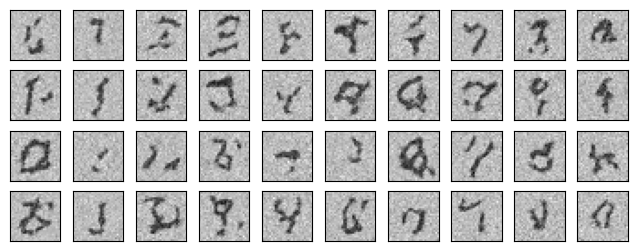

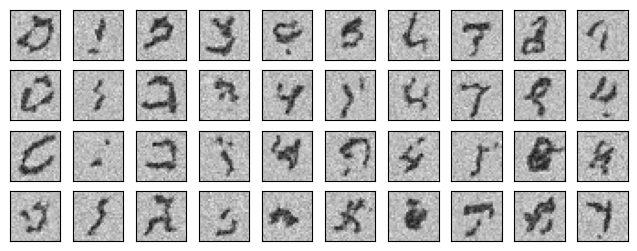

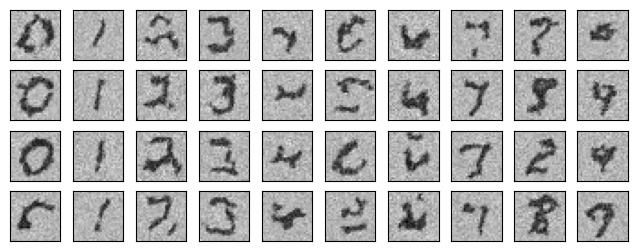

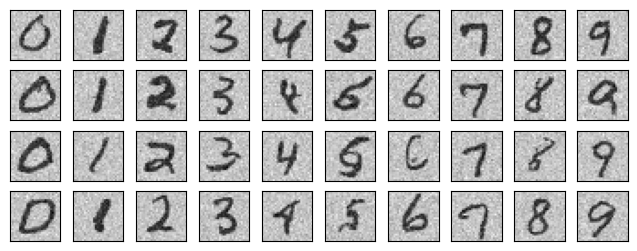

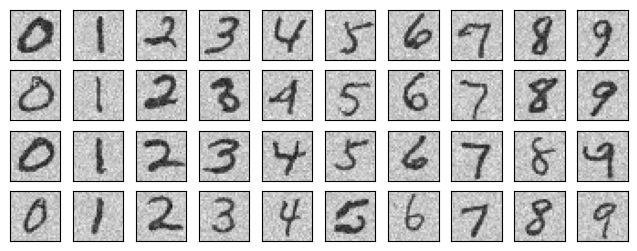

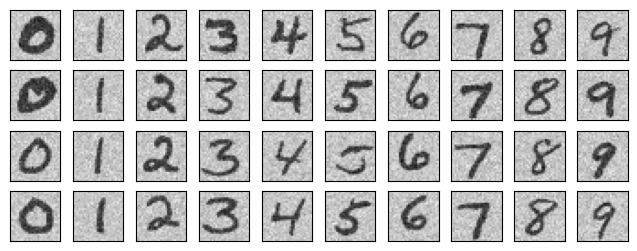

In [16]:
save_dir = './data/diffusion_outputs10/'
os.makedirs(save_dir, exist_ok=True)

lrate = 1e-4
optim = torch.optim.Adam(model.parameters(), lr=lrate)

save_model = False
for ep in range(n_epoch):
    print(f'epoch {ep}')
    x, c = train(model, device, dataloader, optim, ep)

    if ep == 0 or ep == int(n_epoch-1):
        test(model, device, x, c, ep, save_dir)

    # optionally save model
    if save_model and ep == int(n_epoch-1):
        torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

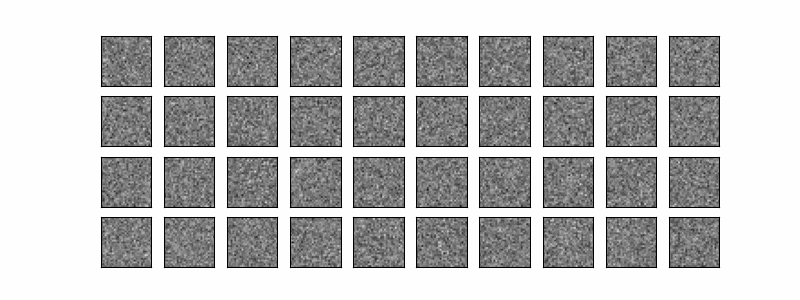

In [17]:
from IPython.display import Image

Image(os.path.join(save_dir, "gif_ep0_w2.0.gif"), format='png')

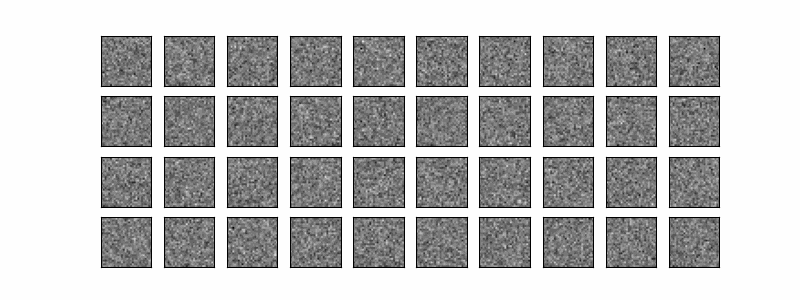

In [18]:
Image(os.path.join(save_dir, "gif_ep19_w2.0.gif"), format='png')